# Volt-var control
In this example, we investigate the effects on voltages by controlling reactive power injection. We adopt the single-phase Linear DistFlow model for simplicity. The purpose of this example is not to develop a sophisticated control algorithm, but rather show the example usage of our dataset and helper functions.

## Data preparation
Because we do not directly measure all of the 2.4kV nodes, we first run state estimation to get the un-measured voltages and currents. 

In [1]:
import os, sys
assert os.getcwd().endswith('digital-twin-dataset/code_examples'), os.getcwd()
sys.path.append(os.path.join(os.getcwd(), '../utils'))
sys.path.append(os.path.join(os.getcwd(), '../code_examples'))
from state_estimation_phasor import StateEstimator, get_timeseries
from global_param import FILE_PATHS, JOIN_CHAR

keep_cc = [0]
prune_nodes = ["bus_1130|bus_1142|bus_1144|bus_1146|bus_1147"]
prune_edges = []
output_data_dir = '../temp/state_estimation_BFM'
datetimespan = ('2024-11-14T07:00:00', '2024-11-14T07:05:00')
state_estimator = StateEstimator(
    network_files=[os.path.join(FILE_PATHS['net_files'], 'circuit3')], 
    input_data_dir=FILE_PATHS['phasors'],
    output_data_dir=output_data_dir,
    phase_ref='bus_1038.ag',
    delta_t_threshold=1.0,
)
state_estimator.state_estimation(datetimespan, print_info=False)

Distinct topologies starting at the following timestamps: ['2024-11-13T23:30:42.000000']


100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


In [ ]:
from state_estimation_phasor import plot_results
elements_to_plot = ['bus_1033', 'bus_1034', 'bus_1118', 'bus_1082', 'bus_1097', 'bus_1106', 'bus_1069']
elements_to_plot += ['line_381', "cb_146", "cb_137", "cb_140", "cb_143", "cb_134"]
outdir = '../temp/state_estimation_plots/results_BFM'
# The state estimation results are plotted in outdir
plot_results(output_data_dir, datetimespan, elements_to_plot, outdir=outdir, ext='png', combine_3_phase=True, show=False)

[Warning] No ground truth measurement data for bus_1034.


### Load circuit topology and parameters
First, prune electrical network.

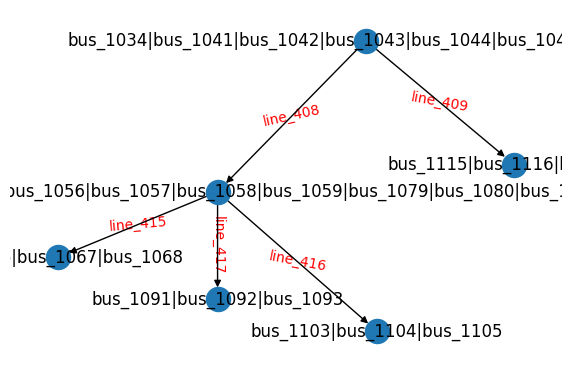

In [3]:
import utils
import topology
import networkx as nx

net_files = [os.path.join(FILE_PATHS['net_files'], 'circuit3')]

# Initialize element inheritance lookup dictionary
element_inheritance = utils.load_json(FILE_PATHS["element_inheritance"])
element_parents = utils.dict_parents(element_inheritance)
# Load network files & generate graph
net_data = topology.load_net_files(net_files, t=datetimespan[0])
nodes_c, edges_c, decorators_c = topology.net2graph(net_data, element_parents)
nodes_e, edges_e, decorators_e = \
    topology.graph2electrical_graph(nodes_c, edges_c, {}, net_data, element_parents)
edge_info = topology.to_edge_dict(edges_e, flip=False)  # edge node -> node tuple
G = nx.DiGraph(topology.to_edge_list(edges_e))
if keep_cc:
    cc = nx.weakly_connected_components(G)
    keep_nodes = utils.flatten_iterable([list(c) for i, c in enumerate(cc) if i in keep_cc], 2)
    G = G.subgraph(keep_nodes).copy()
    nodes_e = {k: v for k, v in nodes_e.items() if k in G.nodes}
    edges_e = {k: v for k, v in edges_e.items() if edge_info[k] in G.edges}
if prune_nodes:
    G.remove_nodes_from(prune_nodes)
    for node in prune_nodes:
        del nodes_e[node]
        to_delete = [e for e, el in edges_e.items() if node in (el['source'], el['target'])]
        for node in to_delete:
            del edges_e[node]
        to_delete = [edge_info[e] for e in to_delete]
        G.remove_edges_from(to_delete)
if prune_edges:
    G.remove_edges_from([edge_info[e] for e in prune_edges])
    for edge in prune_edges:
        del edges_e[edge]
# Remove all transformers
edge_dict = topology.to_edge_dict(edges_e, flip=True)   # node tuple -> edge node
all_transformers = [e for e in G.edges if edges_e[edge_dict[e]]['element_type'] == 'Transformer']
G.remove_edges_from(all_transformers)
G.remove_nodes_from(list(nx.isolates(G)))
# Update graph information
nodelist = list(nx.topological_sort(G))
edgelist = [edge_dict[e] for e in G.edges]
nodes = {k: nodes_e[k] for k in nodelist}
edges = {v: edges_e[v] for v in edge_dict.values() if v in edgelist}
# Plot the pruned final graph
topology.plot_nx_graph(G, edge_info=edge_dict, figsize=(6, 4))
    

Build R, X matrices.

In [4]:
import numpy as np

R_matrix, X_matrix, C_matrix = None, None, None
assert nx.is_tree(G), "The network is not a tree."
assert len(G.nodes) == len(G.edges) + 1, (len(G.nodes), len(G.edges))
N = len(G.nodes) - 1
C_matrix = nx.incidence_matrix(G, oriented=True, nodelist=nodelist).toarray()
C_hat = C_matrix[1:, :]
C_inv = np.linalg.inv(C_hat)
resistances, reactances = np.zeros(N), np.zeros(N)
for i, edge_tuple in enumerate(G.edges):
    edge_name = edge_dict[edge_tuple]
    edge_element = topology.get_element(edges[edge_name], net_data)
    if "Line" in element_parents[edges[edge_name]['element_type']]:
        y, zero_impedance = topology.line_Y_matrix(edge_element, returned_matrix='series Z')
        resistances[i] = np.real(np.diag(y)[:3]).mean()
        reactances[i] = np.imag(np.diag(y)[:3]).mean()
    else:
        raise RuntimeError(f"Unsupported edge type: {edge_element['element_type']}.")
    if zero_impedance:
        raise RuntimeError(f"Zero impedance detected in edge: {edge_name}.")
R_matrix = C_inv.T @ np.diag(resistances) @ C_inv
X_matrix = C_inv.T @ np.diag(reactances) @ C_inv
print(R_matrix.shape, X_matrix.shape)

(5, 5) (5, 5)


### Load timeseries voltage and current phasor.

In [5]:
# Hardcoded input values: nodal voltage and current injection files
slackbus = "bus_1034|bus_1041|bus_1042|bus_1043|bus_1044|bus_1045|bus_1046"
nonzero_injections = {
    "bus_1034|bus_1041|bus_1042|bus_1043|bus_1044|bus_1045|bus_1046": {
        'I': [
            {"element": "tr_117", "terminal": 1, "sign":+1}, 
        ],
        'V': "bus_1042",
    },
    "bus_1115|bus_1116|bus_1117": {
        'I': [
            {"element": "tr_127", "terminal": 0, "sign":-1}, 
        ],
        'V': "bus_1115",
    },
    "bus_1054|bus_1055|bus_1056|bus_1057|bus_1058|bus_1059|bus_1079|bus_1080|bus_1081": {
        'I': [
            {"element": "tr_121", "terminal": 0, "sign":-1}
        ],
        'V': "bus_1054",
    },
    "bus_1066|bus_1067|bus_1068": {
        'I': [
            {"element": "tr_119", "terminal": 0, "sign":-1}, 
        ],
        'V': "bus_1066",
    },
    "bus_1103|bus_1104|bus_1105": {
        'I': [
            {"element": "tr_125", "terminal": 0, "sign":-1}, 
        ],
        'V': "bus_1103",
    },
    "bus_1091|bus_1092|bus_1093": {
        'I': [
            {"element": "tr_123", "terminal": 0, "sign":-1}, 
        ],
        'V': "bus_1091",
    },
}

se_df_cache, se_metadata_cache = {}, {}
s_inj, v_nodal, time_col = [], [], None
for node in nodelist:
    if node in nonzero_injections:
        data = nonzero_injections.pop(node)
        currents = []
        for d in data['I']:
            df = get_timeseries(d['element'], datetimespan, se_df_cache, se_metadata_cache, data_dir=output_data_dir)                
            df = df[d['terminal']] if type(df) is tuple else df     # Determine tbus/fbus
            currents.append(np.stack([df['a'], df['b'], df['c']], axis=1) * d['sign'])
            assert (time_col is None) or (time_col == df['t']).all(), (time_col, df['t'])
            time_col = df['t']
        I = np.stack(currents, axis=0).sum(axis=0)
        df = get_timeseries(data['V'], datetimespan, se_df_cache, se_metadata_cache, data_dir=output_data_dir)
        V = np.stack([df['a'], df['b'], df['c']], axis=1)
        assert (time_col is None) or (time_col == df['t']).all(), (time_col, df['t'], node, data['V'])
        time_col = df['t']
        s_inj.append(V * np.conjugate(I))
        v_nodal.append(V)
    else:
        node_name = node.split('|')[0]
        df = get_timeseries(node_name, datetimespan, se_df_cache, se_metadata_cache, data_dir=output_data_dir)                
        assert (time_col is None) or (time_col == df['t']).all(), (time_col, df['t'])
        time_col = df['t']
        s_inj.append(np.zeros((len(time_col), 3), dtype=np.csingle))
        v_nodal.append(np.stack([df['a'], df['b'], df['c']], axis=1))
assert len(nonzero_injections) == 0, f"Input data not used: {list(nonzero_injections.keys())}"

# Stack data matrices
v_nodal = np.abs(np.stack(v_nodal, axis=0)) ** 2
s_inj = np.stack(s_inj, axis=0)
p_inj, q_inj = np.real(s_inj), np.imag(s_inj)
# Single-phase conversion
p_inj, q_inj, v_nodal = p_inj.mean(axis=-1), q_inj.mean(axis=-1), v_nodal.mean(axis=-1)
print(p_inj.shape, q_inj.shape, v_nodal.shape)

(6, 25) (6, 25) (6, 25)


In [6]:
def plot_lindistflow(time_col, v_nodal, p_inj, q_inj, nodelist, V_pu=1):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    timefmt = mdates.DateFormatter('%M:%S')
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    v_labels = [node.split(JOIN_CHAR)[0] for node in nodelist]
    ax[0].plot(time_col, (v_nodal.transpose() ** 0.5) / V_pu, label=v_labels)
    ax[0].set_title('Bus Voltage')
    ax[0].set_xlabel('Time (minute:second)')
    ax[0].set_ylabel('Voltage (pu)')
    ax[0].legend(loc='upper right')
    ax[0].xaxis.set_major_formatter(timefmt)
    ax[1].plot(time_col, p_inj.transpose()/1e3, label=v_labels)
    ax[1].set_title('Real power injection')
    ax[1].set_xlabel('Time (minute:second)')
    ax[1].set_ylabel('Real Power (kW)')
    ax[1].legend(loc='upper right')
    ax[1].xaxis.set_major_formatter(timefmt)
    ax[2].plot(time_col, q_inj.transpose()/1e3, label=v_labels)
    ax[2].set_title('Reactive power injection')
    ax[2].set_xlabel('Time (minute:second)')
    ax[2].set_ylabel('Reactive Power (kVar)')
    ax[2].legend(loc='upper right')
    ax[2].xaxis.set_major_formatter(timefmt)
    plt.tight_layout()

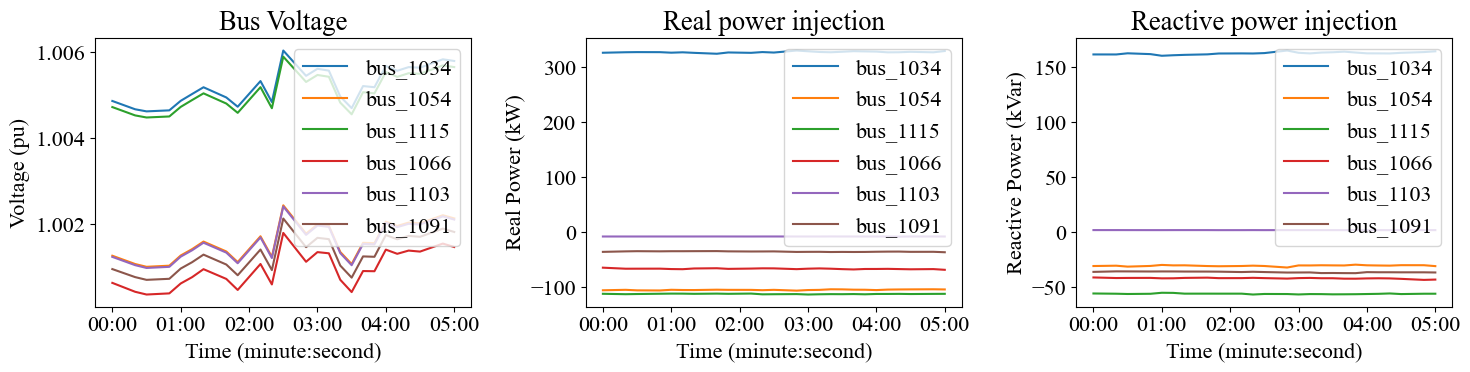

In [ ]:
# These are the voltages without reactive power controllers
plot_lindistflow(time_col, v_nodal, p_inj, q_inj, nodelist, V_pu=2.4e3/3**0.5)

# Voltage control
Here we use a simple proportional controller based on previous timestamps.

In [8]:
p_inj_ctrl = p_inj.copy()
q_inj_ctrl = q_inj.copy()
v_simulation = v_nodal.copy()
v_simulation[1:, 0] = v_nodal[:1, 0] + 2 * (R_matrix @ p_inj[1:, 0] + X_matrix @ q_inj[1:, 0])
for t in range(1, len(time_col)):
    # Control law: proportional control based on previous timestep's voltage
    q_inj_ctrl[1:, t] += (v_simulation[1:, t-1] - 1) * [1.5e-2, 1.5e-2, 1.5e-2, 1.5e-2, 1.5e-2]
    v_simulation[1:, t] = v_nodal[:1, t] + 2 * (R_matrix @ p_inj_ctrl[1:, t] + X_matrix @ q_inj_ctrl[1:, t])

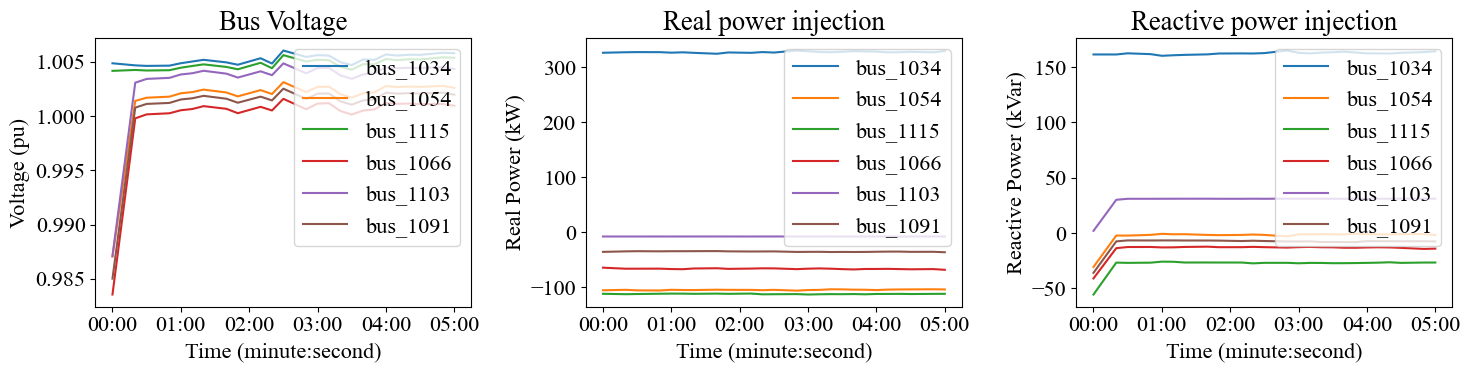

In [9]:
plot_lindistflow(time_col, v_simulation, p_inj_ctrl, q_inj_ctrl, nodelist, V_pu=2.4e3/3**0.5)